In [1]:
pip install contractions

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
np.random.seed(0)
import re
from tqdm import tqdm
from bs4 import BeautifulSoup
import pickle
import multiprocessing
from datetime import datetime
import contractions
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, BatchNormalization, Bidirectional, LayerNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import sparse_categorical_crossentropy as scc
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import math
import os
import email
from nltk.translate import bleu_score
from time import time
import joblib

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.gridspec as gridspec
import matplotlib.colors as cm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading punkt: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

<h1> Real Time Assisted Writing for Emails</h1>

This case study is based on the research paper from Google research titled **[Gmail Smart Compose: Real-Time Assisted Writing](https://https://arxiv.org/pdf/1906.00080.pdf)**. The paper presents a system for generating interactive, real-time text suggestions during writing emails in Gmail. This assists users by reducing repetitive typing. To achieve it, the researchers have used user composed email data from Gmail itself for training the models while maintaning all the required privacy standards.

We cannot access these data, so for the case study, we will use Enron Email dataset which is publicly available.

**Enron Corporation** was an American energy, commodities, and services company based in Houston, Texas. The Enron email dataset contains emails generated by employees of the Enron Corporation. It was obtained by the Federal Energy Regulatory Commission of United States of America during its investigation of Enron's collapse. The link to the dataset used here is: https://www.kaggle.com/datasets/wcukierski/enron-email-dataset. This dataset is a collection of emails from Enron Corporation comprising of head, body and tail of the email.

--Problem Statement

1. Create a model which provides real time text suggestions during composition of an email.

Using this model will help users of the email service provider to avoid repetitive writing and provide better suggestions.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/emails.csv")

# Data Overview

In [ ]:
print("\033[1mDataset\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(df.shape[0]))
print("Number of Features: \033[1m{}\033[0m".format(df.shape[1]))
df.head()

Dataset
Number of Data Points: 517401
Number of Features: 2


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


<h3>Column Details:-</h3>

* **file:** The file path in which original email was stored
* **message:** The email with its head, body and tail

# Basic Data Cleaning

Since this is a real time user typed data, it contains a lot of errors and unnecessary texts which we need to clean before proceeding further with our model.

> For our work, we only need the body of the email. So we will extract the body from all emails and discard the rest.

In [ ]:
messages = [email.message_from_string(i) for i in tqdm(df['message'])]

100%|██████████| 517401/517401 [01:13<00:00, 7068.58it/s]


In [ ]:
def get_content(text):
    """
    Get content from email
    """
    parts = []
    for part in text.walk():
        if part.get_content_type() == 'text/plain':
            parts.append(part.get_payload())
    return ''.join(parts)

In [ ]:
df['content'] = [get_content(i) for i in tqdm(messages)]

100%|██████████| 517401/517401 [00:03<00:00, 132566.14it/s]


In [ ]:
df.drop(['file', 'message'], axis=1, inplace=True)

In [ ]:
df.head()

,content
0,Here is our forecast\n\n
1,Traveling to have a business meeting takes the...
2,test successful. way to go!!!
3,"Randy,\n\n Can you send me a schedule of the s..."
4,Let's shoot for Tuesday at 11:45.


<h3>Checking for Duplicate Data</h3>

> First we will check for duplicate data-points

In [ ]:
print("Number of Duplicate Data-Points: \033[1m{}\033[0m".format(df[df.duplicated()].shape[0]))

Number of Duplicate Data-Points: 268376


> We have a large number of data-points having duplicate values of **content**. Keeping only the first data-point, we will drop all other duplicate data-points

In [ ]:
df.drop_duplicates(subset=['content'], inplace=True)

<h3> Check for Null values</h3>

> We will check for Null values in **content** column

In [ ]:
print("Number of \033[1mNull\033[0m values in \033[1mcontent\033[0m column: \033[1m{}\033[0m".format(df[df['content'].isna()].shape[0]))

Number of Null values in content column: 0


> We do not have any Null values in **content** column.

# Data Cleaning: Text Pre-Processing

<h3>Basic Text Cleaning</h3>

> Upon going through the content, we found some garbage emails like the following

In [ ]:
df[df['content'].str.contains('Outlook Migration Team@ENRON')].iloc[0]['content']

'\n---------------------- Forwarded by Phillip K Allen/HOU/ECT on 05/01/2001 0=\n2:14 PM ---------------------------\n\n\nOutlook Migration Team@ENRON\n04/27/2001 01:01 PM\nTo:=09Allison Horton/NA/Enron@ENRON, Amir Baig/NA/Enron@ENRON, Brandon Bang=\nerter/NA/Enron@Enron, Brian Ellis/Corp/Enron@Enron, Charles Philpott/HR/Cor=\np/Enron@ENRON, Chris P Wood/NA/Enron@Enron, Chris Tull/HOU/ECT@ECT, Dale Sm=\nith/Corp/Enron@ENRON, Dave June/NA/Enron@ENRON, Donald Sutton/NA/Enron@Enro=\nn, Felicia Buenrostro/HR/Corp/Enron@ENRON, Johnna Morrison/Corp/Enron@ENRON=\n, Joe Dorn/Corp/Enron@ENRON, Kathryn Schultea/HR/Corp/Enron@ENRON, Leon McD=\nowell/NA/Enron@ENRON, Leticia Barrios/Corp/Enron@ENRON, Milton Brown/HR/Cor=\np/Enron@ENRON, Raj Perubhatla/Corp/Enron@Enron, Shekar Komatireddy/NA/Enron=\n@Enron, Andrea Yowman/Corp/Enron@ENRON, Angie O\'Brian/HR/Corp/Enron@ENRON, =\nBonne Castellano/HR/Corp/Enron@ENRON, Gwynn Gorsuch/NA/Enron@ENRON, Jo Ann =\nMatson/Corp/Enron@ENRON, LaQuitta Washington/H

In [ ]:
df[df['content'].str.contains('Trade Counts and Volume')].iloc[0]['content']

'EnronOnline\nTrade Counts and Volume for May 14, 2001 \n\t\t\tEXTERNAL\t\tINTERNAL\t\tTOTAL\t\t\nCOUNTRY\tCOMMODITY\tCATEGORY\tCOUNT\tQTY\tCOUNT\tQTY\tCOUNT\tQTY\tUNIT OF MEASURE\nAustria\tPower\tPhysical\t        13 \t           10,300 \t        -   \t                 \n  -   \t        13 \t           10,300 \tMWh\nBelgium\tNatural Gas\tPhysical\t        10 \t      1,065,000 \t        -   \t                \n   -   \t        10 \t      1,065,000 \tMMBtu\nCanada\tNatural Gas\tFinancial\t          7 \t      3,655,000 \t          1 \t         \n155,000 \t          8 \t      3,810,000 \tMMBtu\nCanada\tNatural Gas\tPhysical\t      235 \t    14,076,271 \t        -   \t                   \n-   \t      235 \t    14,076,271 \tMMBtu\nCanada\tPower\tFinancial\t        18 \t           20,642 \t        -   \t                 \n  -   \t        18 \t           20,642 \tMWh (Canada)\nFrance\tPower\tPhysical\t          1 \t             4,741 \t        -   \t                \n   -   \t          1 \t  

In [ ]:
df = df[~df['content'].str.contains('Outlook Migration Team@ENRON')]
df = df[~df['content'].str.contains('Trade Counts and Volume')]

In [ ]:
df

,content
0,Here is our forecast\n\n
1,Traveling to have a business meeting takes the...
2,test successful. way to go!!!
3,"Randy,\n\n Can you send me a schedule of the s..."
4,Let's shoot for Tuesday at 11:45.
...,...
517396,This is a trade with OIL-SPEC-HEDGE-NG (John L...
517397,Some of my position is with the Alberta Term b...
517398,2\n\n -----Original Message-----\nFrom: \tDouc...
517399,Analyst\t\t\t\t\tRank\n\nStephane Brodeur\t\t\...


> Removing short forms of **Reply** and **Forward** from **content** column

In [ ]:
l=re.compile("re:\s*|fw:\s*|fwd:\s*|fwd\s*", re.IGNORECASE)
df['content']=df['content'].apply(lambda x: l.sub(" ", x))

> Removing **newline** and **tab** escape characters from **content** column

In [ ]:
df['content']=df['content'].apply(lambda x: re.sub("[\n\t]", " ", x))

> Removing extra whitespaces from  **content** column

In [ ]:
df['content']=df['content'].apply(lambda x: re.sub("\s+", " ", x))

> Removing leading and trailing whitespaces from text in **content** column

In [ ]:
df['content']=df['content'].str.strip()

> Removing duplicates if any formed due to above steps

In [ ]:
df[df.duplicated()].shape[0]

5503

In [ ]:
df.drop_duplicates(subset=['content'], inplace=True)

> Expanding contractions in **content** column

In [ ]:
tqdm.pandas()
df['content']=df['content'].progress_apply(lambda x: contractions.fix(x))

100%|██████████| 243440/243440 [00:27<00:00, 8873.82it/s] 


> Removing HTML tags from **content** column

In [ ]:
df['content']=df['content'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text(separator=" ", strip=True))

>The above code snippet is not able to remove Comment tags of HTML format. So we are removing them separately

In [ ]:
df['content']=df['content'].apply(lambda x: re.sub("<\!--.*?-->", "", x))
df['content']=df['content'].apply(lambda x: re.sub("\s+", " ", x))# making sure that extra white spaces are removed from text

> To maintain privacy standards, we are replacing website urls with special token '**url**'

In [ ]:
tqdm.pandas()
l=re.compile('(http\S+)|(www\.\S+)|(\S+\.com)', re.IGNORECASE)
df['content']=df['content'].progress_apply(lambda x: l.sub('url', x))
df['content']=df['content'].apply(lambda x: re.sub("\s+", " ", x))# making sure that extra white spaces are removed from text

100%|██████████| 243440/243440 [00:38<00:00, 6301.34it/s]


> Removing texts with patterns like '**.com**' as these are garbage texts

In [ ]:
l=re.compile("\s\.com", re.IGNORECASE)
df['content']=df['content'].apply(lambda x: l.sub("", x))
df['content']=df['content'].apply(lambda x: re.sub("\s+", " ", x))# making sure that extra white spaces are removed from text

In [ ]:
df.to_csv("/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/1204232212.csv", index=False)

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/1204232212.csv')

> Removing Attachment file names with extensions

In [ ]:
df.drop(df[df['content'].isna()].index, axis=0, inplace=True)

In [ ]:
tqdm.pandas()
lst=["\S+\s*\.dat", "\S+\s*\.xls", "\S+\s*\.pdf", "\S+\s*\.doc", "\S+\s*\.docx", "\S+\s*\.exe", "\S+\s*\.htm", "\S+\s*\.html", "\S+\s*\.net", "\S+\s*\.mso", "\S+\s*\.tif", "\S+\s*\.gif", "\S+\s*\.jpg", "\S+\s*\.jpeg", "\S+\s*\.ppt", "\S+\s*\.zip", "\S+\s*\.txt", "\S+\s*\.csv", "\S+\s*\.pst", "\S+\s*\.nsf", "\S+\s*\.ost", "\S+\s*\.xml", "\S+\s*\.sql", "\S+\s*\.jar", "\S+\s*\.bin", "\S+\s*\.asf", "\S+\s*\.mpeg", "\S+\s*\.pcx", "\S+\s*\.mpg", "\S+\s*\.mp3", "\S+\s*\.als", "\S+\s*\.wmz", "\S+\s*\.png", "\S+\s*\.vcf", "\S+\s*\.aud"]
l=re.compile("|".join(lst), re.IGNORECASE)

df['content']=df['content'].progress_apply(lambda x: l.sub("", x))
df['content']=df['content'].apply(lambda x: re.sub("\s+", " ", x))# making sure that extra white spaces are removed from text

Now, many email contents have multiple threaded emails in one data-point. These threaded emails are either forwarded emails or replied emails. For increasing performance of our model, we will be separating these threaded emails into individual emails.

From our analysis, we found that most of these threaded emails are preceded by texts like **'Forwarded by'** or **'Original Message'** followed by details of sender, receiver, date and time of sending and subject.

So, to separate the threaded emails, we will identify the indexes of message texts like **'Forwarded Message'** and **'Original Message'**, then create new subtrings between these message texts like from first **'Forwarded Message'** to the next **'Forwarded Message'**. Then within those substrings, we will search for text like **'Subject:'** and **'From:'** to extract the actual content of the individual email.

This individual email is added in a list in a sequential manner which is added in a separate column called **'mail_list'** and the number of emails is stored in a variable which is added in a separate column called **'mail_list_len'**.

In [ ]:
def mail_sep(s):
    
    '''This function takes subject text and content text as input and gives a list with all individual texts'''
    
    #l will contain start and end indexes of 'Forwarded by' and 'Original Message' text. 
    l=[i.span() for i in re.finditer('---------------------- Forwarded by', s)]
    l.extend([i.span() for i in re.finditer('-----Original Message-----', s)])
    l.append((len(s), len(s))) # length of entire text is added at last so as to have atleast one element in the list
    l.sort()
    
    idx=0 # idx will store end index of the above texts from l
    lst=[] # lst will be the list of all individual texts of the threaded email
    for i in l:
        #txt will store the substring text between two 'Forwarded by' or 'Original Message' text messages
        txt=s[idx:i[0]]
        txt=re.sub("[-+]", "", txt)
        txt=txt.strip()
        l_sub=[j.span() for j in re.finditer("Subject:\s*", txt)] # l_sub will contain start and end indexes of 'Subject:' text in the txt substring
        l_sub.append((len(txt), len(txt))) # length of entire substring text is added at last so as to have atleast one element in the list
        l_sub.sort()
        idx=i[1]
        
        if len(l_sub)>1: # if there is atleast one 'Subject:' text in the substring
            
            if len(l)>1: # if there is atleast one 'Forwarded by' or 'Original Message' in the original text
                idx_sub=l_sub[0][1]
                m=1
            else:
                idx_sub=0
                m=0
                
            for j in l_sub[m:]:
                txt_sub=txt[idx_sub:j[0]] # txt_sub will have text from end of one 'Subject:' to start of next 'Subject:' or end of the subtring
                if 'from:' in txt_sub.lower(): # often 'From:' is included in txt_sub as part of the next individual email. We remove it here
                    txt_sub=txt_sub[0:txt_sub.lower().index('from:')]
                if 'sent:' in txt_sub.lower(): # often 'sent:' is included in txt_sub as part of the next individual email. We remove it here
                    txt_sub=txt_sub[0:txt_sub.lower().index('sent:')]
                if 'to:' in txt_sub.lower(): # often 'to:' is included in txt_sub as part of the next individual email. We remove it here
                    txt_sub=txt_sub[0:txt_sub.lower().index('to:')]
                if 'cc:' in txt_sub.lower(): # often 'cc:' is included in txt_sub as part of the next individual email. We remove it here
                    txt_sub=txt_sub[0:txt_sub.lower().index('cc:')]
                if 'bcc:' in txt_sub.lower(): # often 'bcc:' is included in txt_sub as part of the next individual email. We remove it here
                    txt_sub=txt_sub[0:txt_sub.lower().index('bcc:')]
                txt_sub=txt_sub.strip()
                idx_sub=j[1]
                if txt_sub=='':
                    continue
                lst.append(txt_sub)
        else:
            if 'from:' in txt.lower(): # often 'from:' is included in txt_sub as part of the next individual email. We remove it here
                txt=txt[0:txt.lower().index('from:')]
            if 'sent:' in txt.lower(): # often 'sent:' is included in txt_sub as part of the next individual email. We remove it here
                txt=txt[0:txt.lower().index('sent:')]
            if 'to:' in txt.lower(): # often 'to:' is included in txt_sub as part of the next individual email. We remove it here
                txt=txt[0:txt.lower().index('to:')]
            if 'cc:' in txt.lower(): # often 'cc:' is included in txt_sub as part of the next individual email. We remove it here
                txt=txt[0:txt.lower().index('cc:')]
            if 'bcc:' in txt.lower(): # often 'bcc:' is included in txt_sub as part of the next individual email. We remove it here
                txt=txt[0:txt.lower().index('bcc:')]
            txt=txt.strip()
            if txt=='':
                continue
            lst.append(txt)
    
    return lst

In [ ]:
mail_list=[]
for r in tqdm(df.index):
    mail_list.append(mail_sep(df['content'].loc[r]))
mail_list_len=[len(x) for x in mail_list]

df['mail_list']=mail_list
df['mail_list_len']=mail_list_len

100%|██████████| 243440/243440 [00:27<00:00, 8943.56it/s]


In [ ]:
dframe=[]
mail=[]
for i in tqdm(df.index):
    row=[df['content'].loc[i], df['mail_list'].loc[i], df['mail_list_len'].loc[i]]
    for j in df['mail_list'].loc[i]:
        
        dframe.append(row)
        mail.append(j)

dft=pd.DataFrame(dframe, columns=list(df.columns))
dft['Mail']=mail

100%|██████████| 243440/243440 [00:20<00:00, 11836.46it/s]


In [ ]:
dft

,content,mail_list,mail_list_len,Mail
0,Here is our forecast,[Here is our forecast],1,Here is our forecast
1,Traveling to have a business meeting takes the...,[Traveling to have a business meeting takes th...,1,Traveling to have a business meeting takes the...
2,test successful. way to go!!!,[test successful. way to go!!!],1,test successful. way to go!!!
3,"Randy, Can you send me a schedule of the salar...","[Randy, Can you send me a schedule of the sala...",1,"Randy, Can you send me a schedule of the salar..."
4,Let us shoot for Tuesday at 11:45.,[Let us shoot for Tuesday at 11:45.],1,Let us shoot for Tuesday at 11:45.
...,...,...,...,...
434572,Analyst Rank Stephane Brodeur 1 Chad Clark 1 I...,[Analyst Rank Stephane Brodeur 1 Chad Clark 1 ...,1,Analyst Rank Stephane Brodeur 1 Chad Clark 1 I...
434573,i think the YMCA has a class that is for peopl...,[i think the YMCA has a class that is for peop...,4,i think the YMCA has a class that is for peopl...
434574,i think the YMCA has a class that is for peopl...,[i think the YMCA has a class that is for peop...,4,ali's essays i do not know about the heart cla...
434575,i think the YMCA has a class that is for peopl...,[i think the YMCA has a class that is for peop...,4,ali's essays 01:41 PM just send the essay at h...


> Now, to make the contents of the dataset more refined so that our model works better, we would be removing the signing offs and salutations from **content** column. We would proceed one by one and remove them as per various conditions

In [ ]:
tqdm.pandas()
l=re.compile("[^a-zA-Z](best regards|warm regards|brgrds|your(s*) sincerely|sincerely your(s*)|cordially|your(s*) faithfully|faithfully your(s*)|your(s*) respectfully|respectfully your(s*)|thank(s*)).*", re.IGNORECASE)
dft['Mail']=dft['Mail'].progress_apply(lambda x: l.sub("", x))
dft['Mail']=dft['Mail'].apply(lambda x: re.sub("\s+", " ", x))# making sure that extra white spaces are removed from text

100%|██████████| 434577/434577 [00:20<00:00, 21519.48it/s]


In [ ]:
l=re.compile("(sincerely(?!.*sincerely))|(regards(?!.*regards)).*$", re.IGNORECASE)
dft['Mail']=dft['Mail'].progress_apply(lambda x: l.sub("", x))
dft['Mail']=dft['Mail'].apply(lambda x: re.sub("\s+", " ", x))# making sure that extra white spaces are removed from text

100%|██████████| 434577/434577 [00:14<00:00, 29571.91it/s]


In [ ]:
l=re.compile("((dear|hi|hello|greetings)[^a-zA-Z]+[\w]*[^a-zA-Z]*name([^a-zA-Z]+[\w]*[^a-zA-Z]*name)*)", re.IGNORECASE)
dft['Mail']=dft['Mail'].progress_apply(lambda x: l.sub("", x))
dft['Mail']=dft['Mail'].apply(lambda x: re.sub("\s+", " ", x))# making sure that extra white spaces are removed from text

100%|██████████| 434577/434577 [00:18<00:00, 23661.63it/s]


In [ ]:
l=re.compile("^(dear|hi |hello|greetings)[^a-zA-Z]*[\w]+[^a-zA-Z]*", re.IGNORECASE)
dft['Mail']=dft['Mail'].progress_apply(lambda x: l.sub("", x))
dft['Mail']=dft['Mail'].apply(lambda x: re.sub("\s+", " ", x))# making sure that extra white spaces are removed from text

100%|██████████| 434577/434577 [00:05<00:00, 79445.24it/s]


In [ ]:
# making sure that leading and trailing white spaces are removed from text
dft['Mail']=dft['Mail'].apply(lambda x: x.strip())

In [ ]:
# dropping all rows which become empty text due to above process
idx=dft[dft['Mail'].apply(lambda x: x=='')].index
dft.drop(idx, axis=0, inplace=True)

In [ ]:
# the index number of the dataframe is reassigned based on the row number
dft.index=[*range(dft.shape[0])]

# Exploratory Data Analysis

In [ ]:
dft.drop(['content', 'mail_list', 'mail_list_len'], axis=1, inplace=True)

In [ ]:
dft.head()

,Mail
0,Here is our forecast
1,Traveling to have a business meeting takes the...
2,test successful. way to go!!!
3,"Randy, Can you send me a schedule of the salar..."
4,Let us shoot for Tuesday at 11:45.


<h3> Distribution of email text w.r.t number of characters of the email body </h3>

> * Here we will be plotting the distribution of email text w.r.t number of characters of the email and observe the patterns

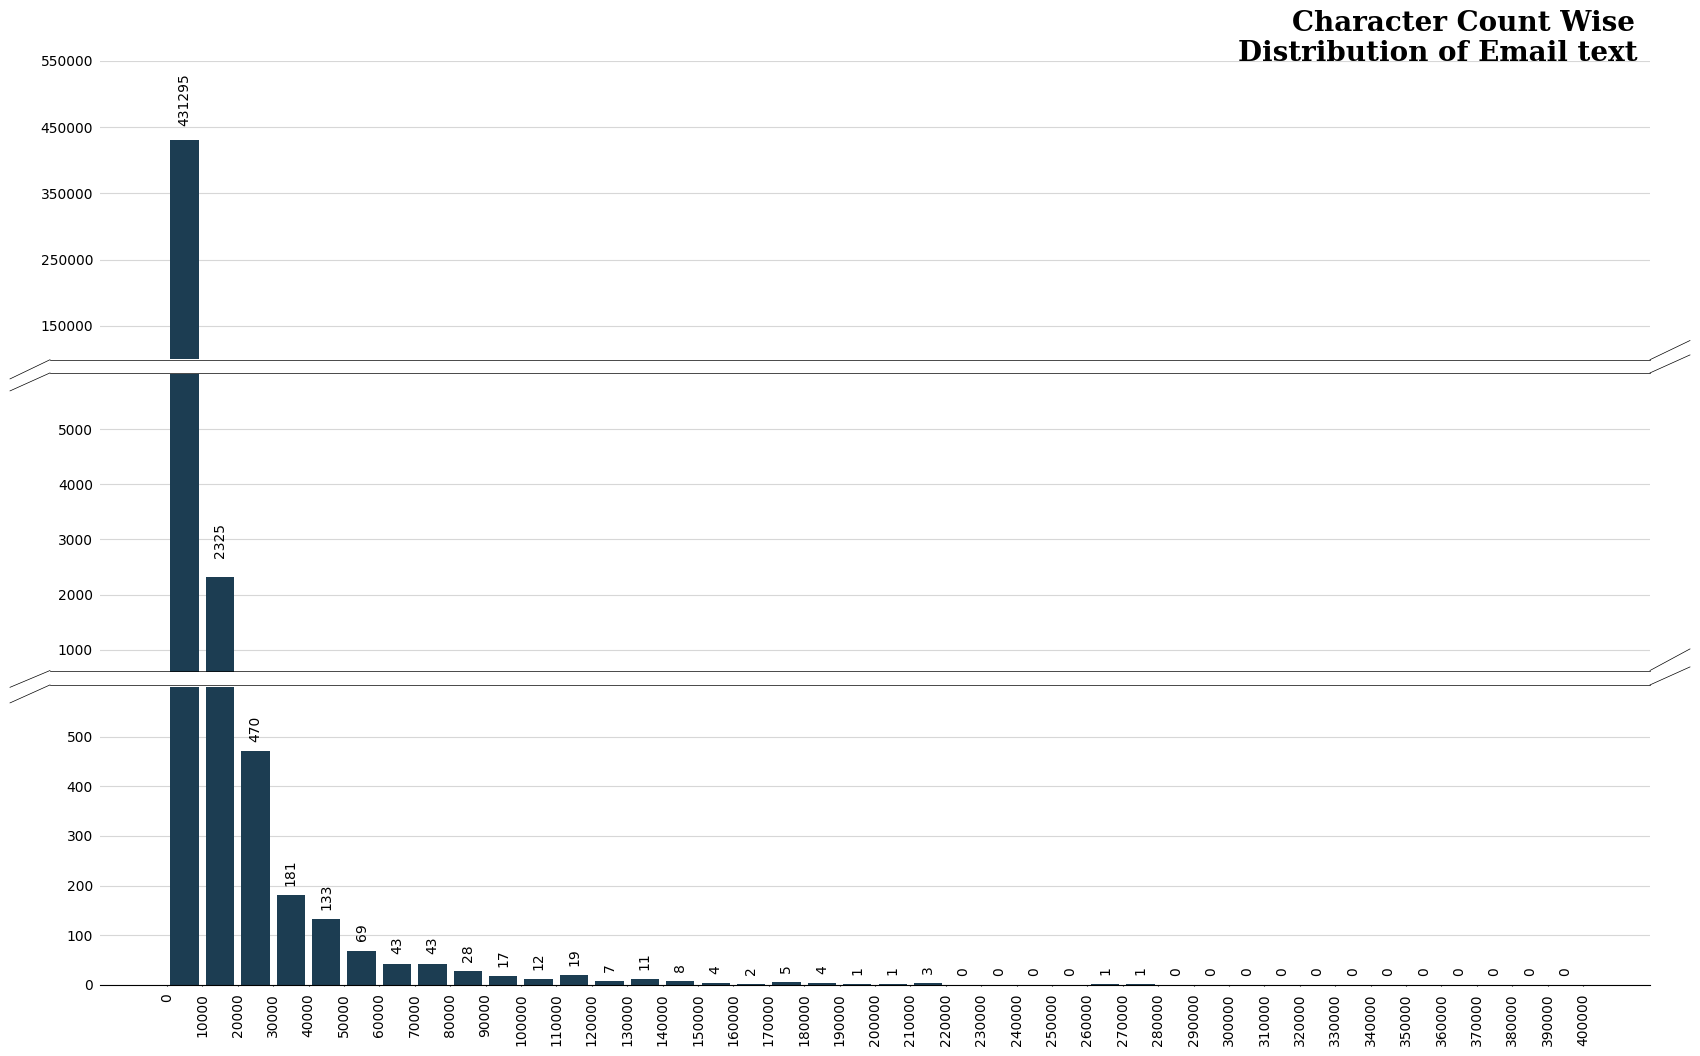

In [ ]:
# Since some of the bins have comparitively high count of words, we had to break the y axis into three parts to accomodate properly all the bars. 
# This is done by plotting three subplots vertically with a common x-axis.

# n_wrd_bdy is a pandas series with index as index number and values as the count of number of words in the email
n_ch_bdy=pd.Series(list(dft['Mail'].values)).apply(lambda x: len(x))

# Three subplots are used with shared x-axis. ax1 corresponds to top subplot and ax2 corresponds to middle subplot and ax3 corresponds to bottom subplot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,12), sharex = True)

fig.text(0.721, 0.905, 'Character Count Wise', fontsize=20, fontweight=600, fontfamily='serif')
fig.text(0.694, 0.88, 'Distribution of Email text', fontsize=20, fontweight=600, fontfamily='serif')

ax1.hist(n_ch_bdy.values, bins=list(range(0, 400001, 10000)), rwidth=0.8, color='#1C3D52')
ax2.hist(n_ch_bdy.values, bins=list(range(0, 400001, 10000)), rwidth=0.8, color='#1C3D52')
ax3.hist(n_ch_bdy.values, bins=list(range(0, 400001, 10000)), rwidth=0.8, color='#1C3D52')

for p in ax1.patches[0:1]:
    ax1.annotate(f"{int(p.get_height())}", xy=(p.get_x()+p.get_width()/4, p.get_y()+p.get_height()+25000), va='baseline', rotation=90)

for q in ax2.patches[1:2]:
    ax2.annotate(f"{int(q.get_height())}", xy=(q.get_x()+q.get_width()/4, q.get_y()+q.get_height()+400), va='baseline', rotation=90)

for r in ax2.patches[2:]:
    ax3.annotate(f"{int(r.get_height())}", xy=(r.get_x()+r.get_width()/4, r.get_y()+r.get_height()+25), va='baseline', rotation=90)

ax3.set_xticks(list(range(0, 400001, 10000))) # bins width is set to 1000
ax3.tick_params(axis='x', pad=5, length=1, labelsize=10, rotation=90)

ax1.set_ylim(100000,500000) # ax1's y-axis limit is set from 100000 to 500000 as it will show only high values
ax1.set_yticks(list(range(150000,550001, 100000)))
ax1.tick_params(axis='y', pad=5, length=0, labelsize=10)
ax2.set_ylim(600,6000) # ax2's y-axis limit is set from 600 to 6000 as it will show only medium values
ax2.set_yticks(list(range(1000,6000, 1000)))
ax2.tick_params(axis='y', pad=5, length=0, labelsize=10)
ax3.set_ylim(0,600) # ax3's y-axis limit is set from 0 to 600 as it will show only low values
ax3.set_yticks(list(range(0,600, 100)))
ax3.tick_params(axis='y', pad=5, length=0, labelsize=10)

#The axis lines on all four sides are removed for top subplot
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
#The axis lines on all four sides are removed for middle subplot
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
#The axis lines on all but bottom side are removed for bottom subplot
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)

ax1.xaxis.set_ticks_position('none') # ax1's ticks on x-axis is removed
ax2.xaxis.set_ticks_position('none') # ax2's ticks on x-axis is removed

# Grid is set for ticks in y-axis only
ax1.grid(axis='y', alpha=0.5)
ax1.set_axisbelow(True)
ax2.grid(axis='y', alpha=0.5)
ax2.set_axisbelow(True)
ax3.grid(axis='y', alpha=0.5)
ax3.set_axisbelow(True)

# Below lines are used as separator to show the break in y-axis
l1a = lines.Line2D([0.08, 0.1], [0.615, 0.631], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
l1b = lines.Line2D([0.08, 0.1], [0.605, 0.620], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
l2a = lines.Line2D([0.1, 0.9], [0.631, 0.631], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
l2b = lines.Line2D([0.1, 0.9], [0.620, 0.620], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
l3a = lines.Line2D([0.9, 0.92], [0.631, 0.647], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
l3b = lines.Line2D([0.9, 0.92], [0.620, 0.635], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
fig.lines.extend([l1a, l1b, l2a, l2b, l3a, l3b])

l4a = lines.Line2D([0.08, 0.1], [0.358, 0.372], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
l4b = lines.Line2D([0.08, 0.1], [0.345, 0.360], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
l5a = lines.Line2D([0.1, 0.9], [0.372, 0.372], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
l5b = lines.Line2D([0.1, 0.9], [0.360, 0.360], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
l6a = lines.Line2D([0.9, 0.92], [0.372, 0.390], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
l6b = lines.Line2D([0.9, 0.92], [0.360, 0.375], transform=fig.transFigure, figure=fig, color='black',lw=0.5)
fig.lines.extend([l4a, l4b, l5a, l5b, l6a, l6b])

fig.subplots_adjust(wspace=0, hspace=0.05)

plt.show()

> * From the above plot, we can observe that a large number of emails have number of characters less than 10000 and comparitively few emails have more than 10000 number of words
> * We should plot and observe the distribution of character count for emails whose number of words is less than 10000

<h3> Distribution of email text w.r.t number of characters of the email body (less than 10000) </h3>

In [ ]:
n_ch_bdy=pd.Series(list(dft['Mail'].values)).apply(lambda x: len(x))
# n_wrd_bdy_10k is a pandas series with index as index number and values as the count of number of characters in the email (less than 10000)
n_ch_bdy_10k=n_ch_bdy[n_ch_bdy<10000]

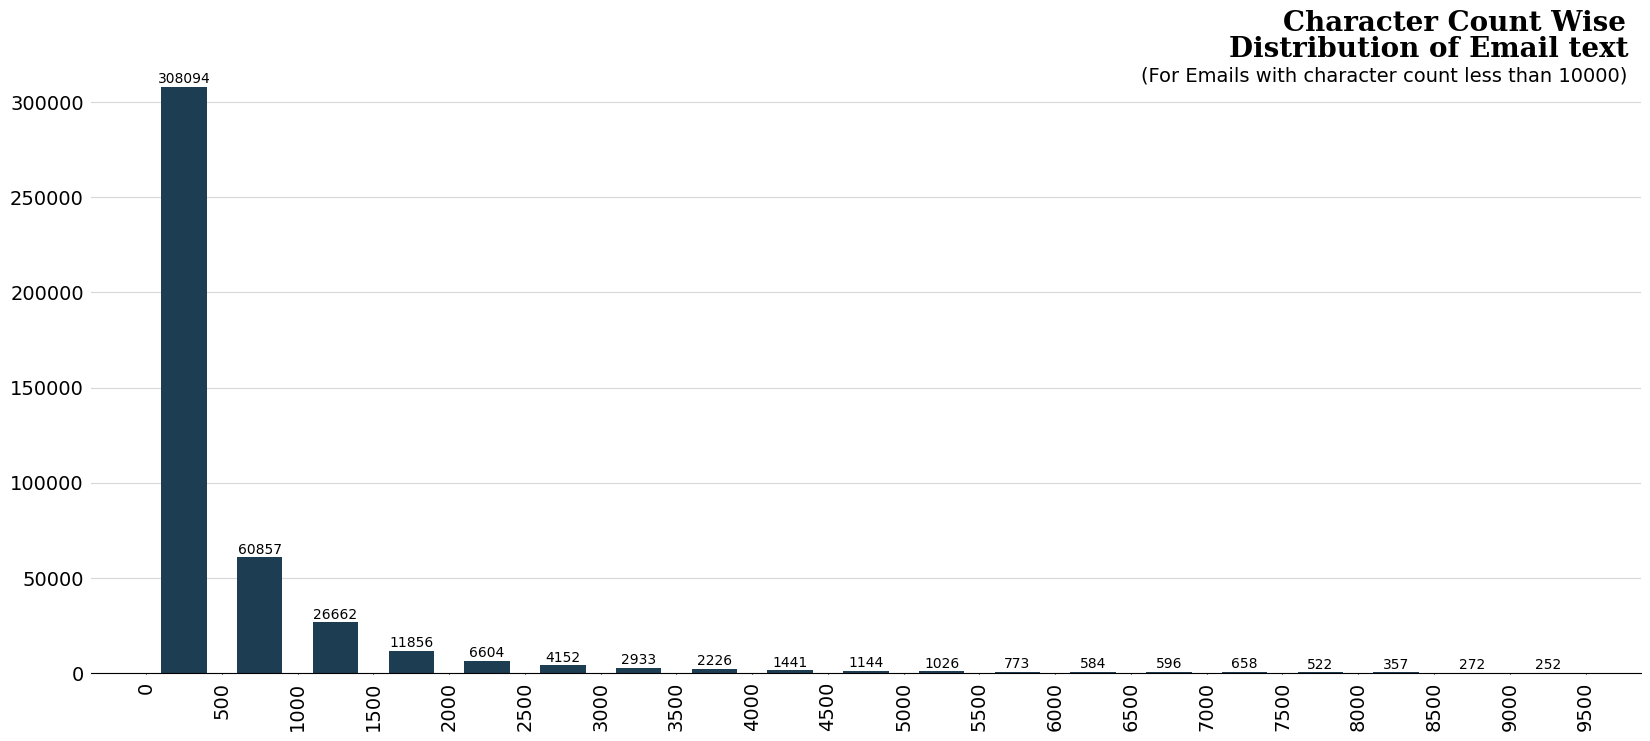

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))

fig.text(0.721, 0.913, 'Character Count Wise', fontsize=20, fontweight=600, fontfamily='serif')
fig.text(0.694, 0.880, 'Distribution of Email text', fontsize=20, fontweight=600, fontfamily='serif')
fig.text(0.650, 0.850, '(For Emails with character count less than 10000)', fontsize=14, fontweight=500)

ax.hist(n_ch_bdy_10k.values, bins=list(range(0, 10000, 500)), rwidth=0.6, color='#1C3D52')

for p in ax.patches[:]:
    ax.annotate(f"{int(p.get_height())}", xy=(p.get_x()+p.get_width()/2, p.get_y()+p.get_height()+2000), ha='center')

ax.set_xticks(list(range(0, 10000, 500)))
ax.tick_params(axis='x', pad=5, length=1, labelsize=14, rotation=90)


ax.set_yticks(list(range(0, 320001, 50000)))
ax.tick_params(axis='y', pad=5, length=0, labelsize=14)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_ticks_position('none')

ax.grid(axis='y', alpha=0.5)
ax.set_axisbelow(True)

plt.show()

> * We can observe that a large number of emails have length less than 500 and  comparitively few emails have more than 500 number of characters
> * We should plot and observe the distribution of character count for emails whose number of words is less than 500

<h3> Distribution of email text w.r.t number of characters of the email body (less than 500) </h3>

In [ ]:
n_ch_bdy=pd.Series(list(dft['Mail'].values)).apply(lambda x: len(x))
# n_wrd_bdy_500 is a pandas series with index as index number and values as the count of number of characters in the email (less than 500)
n_ch_bdy_500=n_ch_bdy[n_ch_bdy<500]

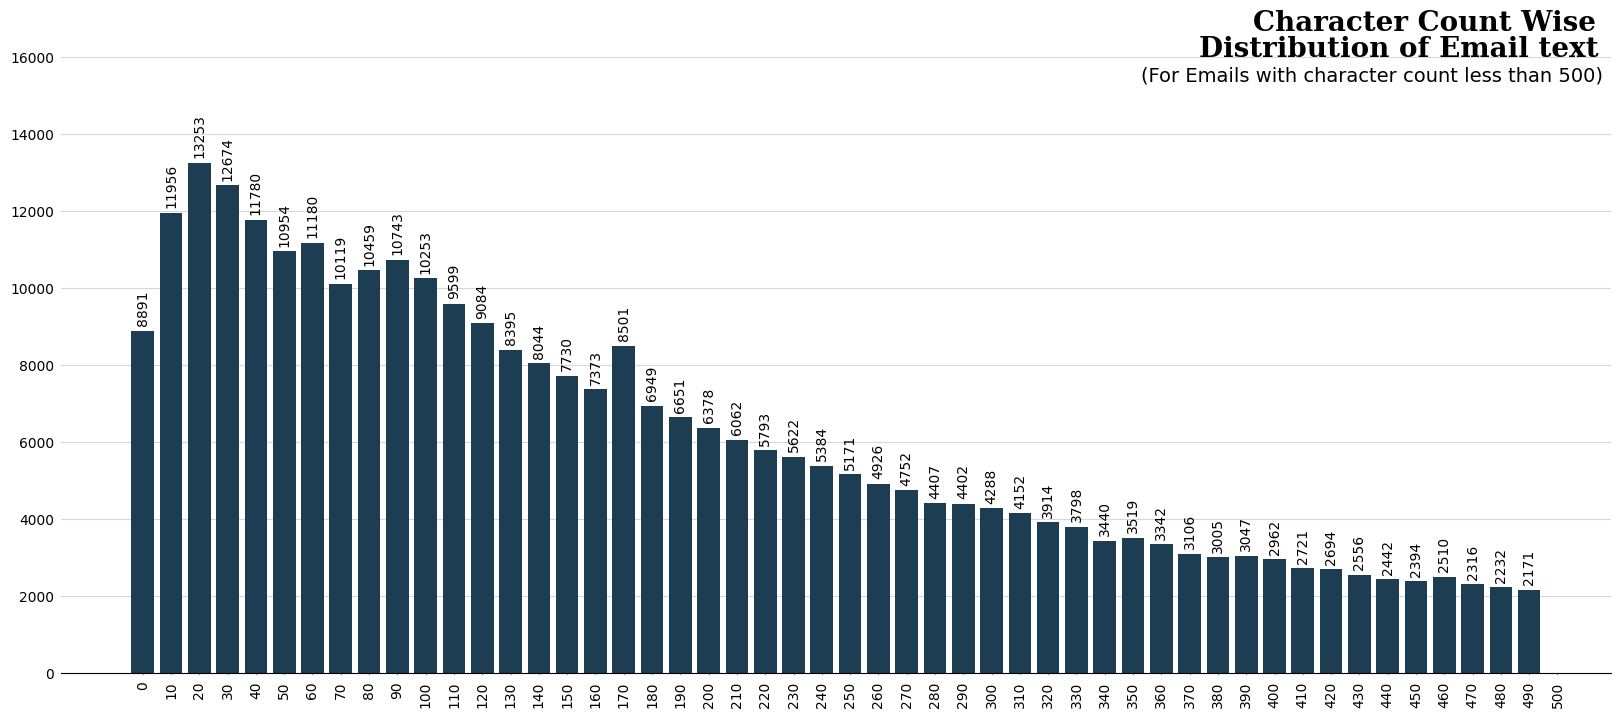

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,8))

fig.text(0.721, 0.913, 'Character Count Wise', fontsize=20, fontweight=600, fontfamily='serif')
fig.text(0.694, 0.880, 'Distribution of Email text', fontsize=20, fontweight=600, fontfamily='serif')
fig.text(0.665, 0.850, '(For Emails with character count less than 500)', fontsize=14, fontweight=500)

ax.hist(n_ch_bdy_500.values, bins=list(range(0, 501, 10)), rwidth=0.8, color='#1C3D52', align='left')

for p in ax.patches[:]:
    ax.annotate(f"{int(p.get_height())}", xy=(p.get_x()+p.get_width()/2, p.get_y()+p.get_height()+200), ha='center', rotation=90)

ax.set_xticks(list(range(0, 501, 10)))
ax.tick_params(axis='x', pad=5, length=1, labelsize=10, rotation=90)

ax.set_yticks(list(range(0, 16001, 2000)))
ax.tick_params(axis='y', pad=5, length=0, labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_ticks_position('none')

ax.grid(axis='y', alpha=0.5)
ax.set_axisbelow(True)

plt.show()

> * We can observe that a lot of the emails have less number of characters . Also the frequency of emails keeps on decreasing gradually as number of characters is increasing. This shows that most of the emails are short and simple and may be to the point. Exactly what is expected from a corporate organization

<h3> Sentiment Analysis of the Emails </h3>

> * Here we will observe the sentiments of the emails sent. To do that we will use the TextBlob function from textblob library which will provide a sentiment score from -1 to +1 with -1 meaning most negative sentiment and +1 meaning most positive sentiment.

In [ ]:
# here we are creating a new column 'Polarity' which will store the polarity of the email body (average polarity if threaded email)
l=[]
for i in tqdm(dft.index):
    x=dft['Mail'].loc[i]
    l.append(round((TextBlob(x).sentiment.polarity),3))
dft['Polarity']=l

100%|██████████| 434687/434687 [06:53<00:00, 1052.08it/s]


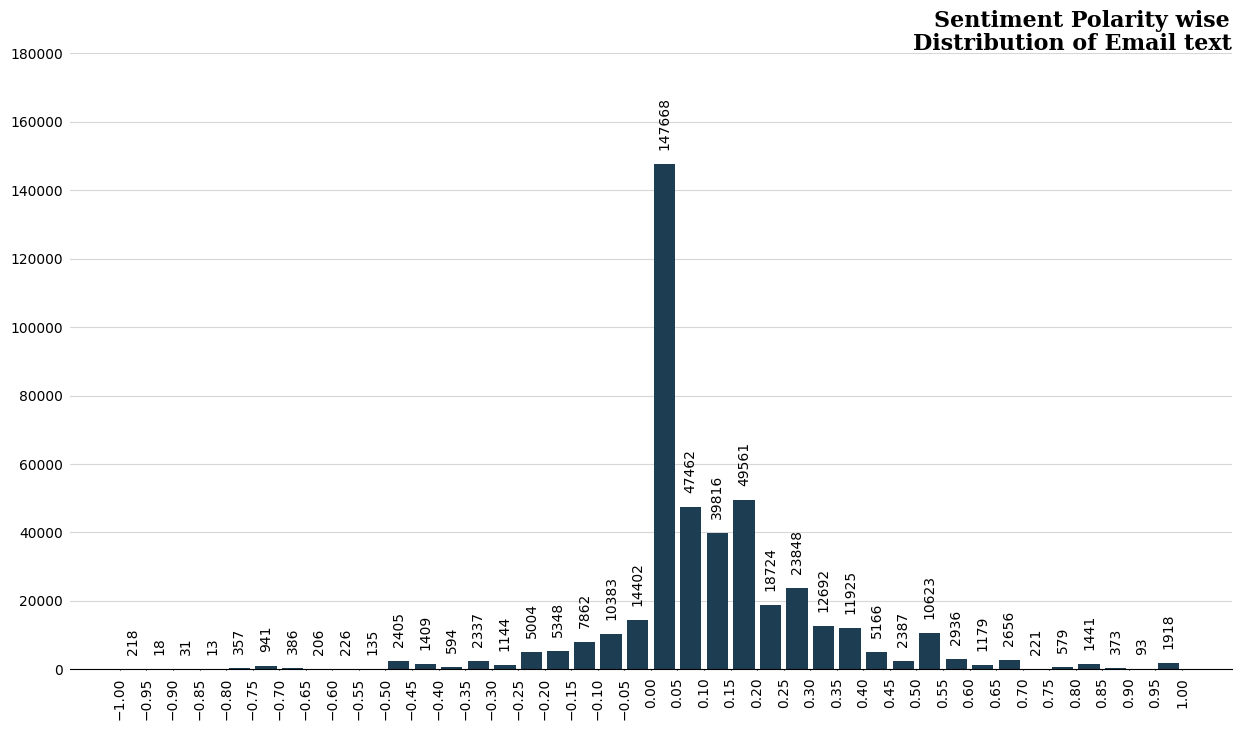

In [ ]:
# plotting sentiment polarity wise distribution of email body
fig, ax = plt.subplots(1, 1, figsize=(15,8))

fig.text(0.701, 0.913, 'Sentiment Polarity wise', fontsize=16, fontweight=600, fontfamily='serif')
fig.text(0.687, 0.884, 'Distribution of Email text', fontsize=16, fontweight=600, fontfamily='serif')

ax.hist(dft['Polarity'].values, bins=np.linspace(-1, 1, 41), rwidth=0.8, color='#1C3D52')

for p in ax.patches[:]:
    ax.annotate(f"{int(p.get_height())}", xy=(p.get_x()+p.get_width()/2, p.get_y()+p.get_height()+5000), ha='center', rotation=90)

ax.set_xticks(np.linspace(-1, 1, 41))
ax.tick_params(axis='x', pad=5, length=1, labelsize=10, rotation=90)

ax.set_yticks(list(range(0, 180001, 20000)))
ax.tick_params(axis='y', pad=5, length=0, labelsize=10)

ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_ticks_position('none')

ax.grid(axis='y', alpha=0.5)
ax.set_axisbelow(True)

plt.show()

> * We can observe that most of the emails are neutral as their polarity lie between 0 to +0.15. There are also extremely negative emails with polarity score between -1.00 and -0.95 and extremely positive emails with polarity score between 0.95 and 1.00

In [ ]:
dft.to_csv("/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/1104231001.csv", index=False)

In [ ]:
dft=pd.read_csv("/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/0804231700.csv")

In [ ]:
dft

,Mail,Polarity
0,Here is our forecast,0.000
1,Traveling to have a business meeting takes the...,0.182
2,test successful. way to go!!!,1.000
3,"Randy, Can you send me a schedule of the salar...",0.000
4,Let us shoot for Tuesday at 11:45.,0.000
...,...,...
434682,Analyst Rank Stephane Brodeur 1 Chad Clark 1 I...,-0.800
434683,i think the YMCA has a class that is for peopl...,0.000
434684,ali's essays i do not know about the heart cla...,0.006
434685,ali's essays 01:41 PM just send the essay at h...,-0.062


# Pre-Modeling

<h3> Extracting individual sentences from pre-processed mail body </h3>

> * For feeding data into our model, we need to first get individual sentences from the mail bodies.

In [ ]:
def get_sentences(content):
    
    sentences_list = []
    for i in content.split('.'):
        
        #Strip the sentence
        sentence = i.strip()
        
        #Consider sentences which have between 3 to 20 words
        if 3<=len(sentence.split())<=20:
            
            #Check if first letter starts with upper case or is a "name" and rest all words are lower case
            if sentence[0].isupper() and sentence[1:].islower():
                
                #Proceed only if the sentence doesn't have any numbers
                if bool(re.search(r'\d', sentence))==False:
                    
                    #Proceed only if the sentence doesn't have any special character
                    regex = re.compile("""[^a-zA-Z\s\?]""")
                    if(regex.search(sentence) == None): 
                        
                        #Split sentence from question mark
                        sentence=sentence.lower()
                        for j in sentence.split('?'):
                            
                            #Proceed only if the splitted sentence has 3 or more words
                            if len(j.split())>=3:
                                sentences_list.append(j)
    return sentences_list

In [ ]:
tqdm.pandas()
lst=[]
for i in tqdm(dft.index):
    lst.extend(get_sentences(dft['Mail'].loc[i]))

100%|██████████| 434687/434687 [00:31<00:00, 13791.85it/s]


In [ ]:
df=pd.DataFrame(lst, columns=['Sentence'])

In [ ]:
# making sure that extra white spaces are removed from text
df['Sentence']=df['Sentence'].apply(lambda x: re.sub("\s+", " ", x))

# making sure that leading and trailing white spaces are removed from text
df['Sentence']=df['Sentence'].apply(lambda x: x.strip())

In [ ]:
#Checking for duplicate sentences after above process
df[df.duplicated()]

,Sentence
24,i have been involved in most of the meetings a...
25,we have had three meetings which brought out v...
26,it will help determine which requests fall und...
27,use the above to formulate a project plan
28,ability to split the current position grid to ...
...,...
294578,there is one tab for each department
294583,if you choose not to comply with any of these ...
294584,if you have any questions please contact me
294585,the other option is that you will just use one...


In [ ]:
#Dropping the duplicate sentences keeping only the first occurence
df.drop_duplicates(inplace=True, ignore_index=True)

In [ ]:
df

,Sentence
0,here is our forecast
1,traveling to have a business meeting takes the...
2,especially if you have to prepare a presentation
3,i would suggest holding the business plan meet...
4,i would even try and get some honest opinions ...
...,...
158945,system restoration plans and roles
158946,i have created a spreadsheet that lists which ...
158947,please keep it updated throughout the day
158948,i just went to the cardiologist for my follow ...


<h3> Removing sentences which contain rare words </h3>

> * Removing sentences with words which occur very rarely in the whole dataset will decrease the number of sentences required to train the model to give same level of performance.

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['Sentence'])

In [ ]:
words = list(dict(tokenizer.word_counts).values())
words.sort(reverse=True)

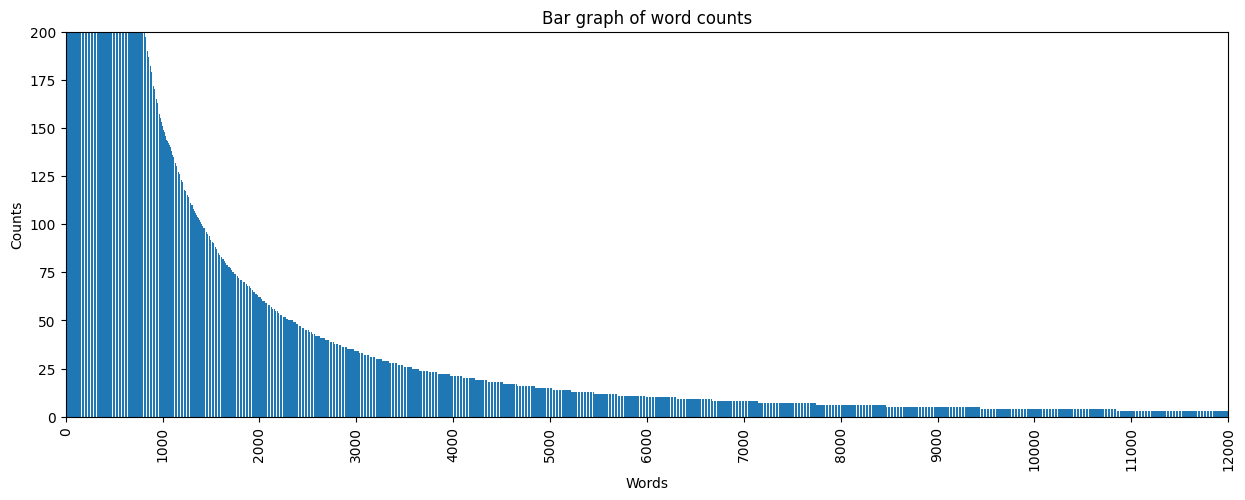

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(range(len(words)),words,align='center')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Bar graph of word counts')
plt.xlim(0,3000)
plt.xticks(range(0,13000,1000),rotation=90)
plt.ylim(0,200)
plt.show()

> * Here we are considering the count of 100 as the threshold of deciding which word is rare as the gradient of the graph above starts decreasing after 120

In [ ]:
vocab = dict()
for i,j in dict(tokenizer.word_counts).items():
    if j>120:
        vocab[i]=j

In [ ]:
len(vocab)

1211

In [ ]:
indices = []
for i in tqdm(range(df.shape[0])):
    for j in df['Sentence'].iloc[i].split():
        if j not in vocab:
            break
    else:
        indices.append(i)

100%|██████████| 158950/158950 [00:01<00:00, 109307.76it/s]


In [ ]:
df1=df.copy()

In [ ]:
df = df.iloc[indices].drop_duplicates()

In [ ]:
df.shape

(50731, 1)

In [ ]:
# the index number of the dataframe is reassigned based on the row number
df.index=[*range(df.shape[0])]

In [ ]:
df.to_csv("/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/1104231014.csv", index=False)

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/1104231014.csv")

In [ ]:
df.head(10)

,Sentence
0,i have been involved in most of the meetings a...
1,i will know more on this question later today
2,i am still doing my own
3,i have my copy of the original deal
4,please see the attached spreadsheet for a trad...
5,call when you have reviewed and we can discuss...
6,call me when you can
7,let me know what you think
8,i will go ahead and mail you another check
9,i know your concerns about the site plan


<h3> Splitting the data into train and test data</h3>

In [ ]:
# Split the dataset into train(75%) and test(25%)
X_tr, X_ts=train_test_split(df, test_size=0.25, random_state=10)

<h3> Creating datapoints from each character of a sentence in the dataset</h3>

In [ ]:
def text_for_model(df):
    
    ''' This function takes a part of dataframe and an index number as input and creates two pickle files one 
        having list of curent mails and another having list of previous mails and stores them in the system as 
        per the index'''
    
    dframe=[]
    for idx in tqdm(df.index):
        
        t=df['Sentence'].loc[idx]
        for j in range(1,len(t)+1):
            
            row=[]
            x=('# '+t[:j]+' *')
            y=('# '+t[j:]+' *')
            row.append(x)
            row.append(y)
            dframe.append(row)
           
    dft=pd.DataFrame(dframe, columns=['X', 'Y'])
    dft.drop_duplicates(inplace=True, ignore_index=True)
    
    return dft

if __name__ == "__main__":

    X_test=text_for_model(X_ts)
    X_train=text_for_model(X_tr)

100%|██████████| 38048/38048 [00:06<00:00, 6180.42it/s] 


In [ ]:
#removing datapoints whose target value is just '#*'
idx=list(X_train[X_train['Y'].apply(lambda x: x=="#  *")].index)
X_train.drop(idx, axis=0, inplace=True)

In [ ]:
#removing datapoints whose target value is just '#*'
idx=list(X_test[X_test['Y'].apply(lambda x: x=="#  *")].index)
X_test.drop(idx, axis=0, inplace=True)

In [ ]:
#removing datapoints whose target value has more than 7 words
X_train=X_train[X_train['Y'].apply(lambda x: len(x.split())<=7)]
X_test=X_test[X_test['Y'].apply(lambda x: len(x.split())<=7)]

<h3> Train and Test data Overview </h3>

In [ ]:
print("\033[1mTrain Dataset\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(X_train.shape[0]))
print("Number of Features: \033[1m{}\033[0m".format(X_train.shape[1]))
X_train.sample(5)

Train Dataset
Number of Data Points: 937720
Number of Features: 2


,X,Y
5495,# i will call in the morn *,# ing *
616564,# sorry it took a *,# while *
1501753,# i agree with your p *,# osition on the rates *
909116,# it seems they were really r *,# equested *
197708,# i *,# received your email *


In [ ]:
print("\033[1mTest Dataset\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(X_test.shape[0]))
print("Number of Features: \033[1m{}\033[0m".format(X_test.shape[1]))
X_test.sample(5)

Test Dataset
Number of Data Points: 313104
Number of Features: 2


,X,Y
482002,# if you require any fu *,# rther assistance please contact me *
330927,# keep close track of these compa *,# nies *
321734,# look at the spreadsheet be *,# low *
306064,# i am not sure w *,# hat you will see today *
413365,# see attached spread s *,# heet *


In [ ]:
X_train_c=X_train.copy()
X_test_c=X_test.copy()

In [ ]:
X_train=X_train_c.copy()
X_test=X_test_c.copy()

In [ ]:
X_train.to_csv("/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/X_train_1904231349.csv", index=False)
X_test.to_csv("/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/X_test_1904231349.csv", index=False)

In [5]:
X_train=pd.read_csv('X_train_1904231349.csv')
X_test=pd.read_csv('X_test_1904231349.csv')

Selecting top 200000 datapoints from train dataset and top 40000 datapoints from test dataset as
original datasets are too large for the resources we have at our disposal

X_train=X_train_c.head(500000)
X_test=X_test_c.head(100000)

<h3> Data tokenization and encoding</h3>

In [6]:
#max_len is th maximum length of input data of a datapoint in train dataset
max_len=X_train['X'].apply(lambda x: len(x)).max()

#tokenizer is a tensorflow function to tokenize characters(here) into integers
tokenizer=Tokenizer(filters='', char_level=True)

#here tokenizer is fitted on input data of train dataset
tokenizer.fit_on_texts(X_train['X'].values)

#tok_keys is a list of characters that are tokenized
tok_keys=list(tokenizer.word_index.keys())

#tok_values is a list of integers whose corresponding index are characters in tok_keys
tok_values=list(tokenizer.word_index.values())

#size of the vocabulary is number of character tokens + 1
vocab_size=len(tok_values)+1

In [7]:
#encoding documents with integers
X_train_encoded_docs = tokenizer.texts_to_sequences(X_train.X)
y_train_encoded_docs = tokenizer.texts_to_sequences(X_train.Y)

X_val_encoded_docs = tokenizer.texts_to_sequences(X_test.X)
y_val_encoded_docs = tokenizer.texts_to_sequences(X_test.Y)

In [8]:
#padding input data of the documents upto max length (max_len)
X_train_padded_docs = tf.keras.preprocessing.sequence.pad_sequences(X_train_encoded_docs, padding='post')
X_val_padded_docs = tf.keras.preprocessing.sequence.pad_sequences(X_val_encoded_docs, maxlen=X_train_padded_docs.shape[1], padding='post')

In [9]:
#padding target data of the documents upto max length (max_len)
y_train_padded_docs = tf.keras.preprocessing.sequence.pad_sequences(y_train_encoded_docs, padding='post')
y_val_padded_docs = tf.keras.preprocessing.sequence.pad_sequences(y_val_encoded_docs, maxlen=y_train_padded_docs.shape[1], padding='post')

In [10]:
print("\033[1mX_train_padded_docs\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(X_train_padded_docs.shape[0]))
print("Number of Columns: \033[1m{}\033[0m".format(X_train_padded_docs.shape[1]))

X_train_padded_docs
Number of Data Points: 937720
Number of Columns: 128


In [11]:
print("\033[1mX_val_padded_docs\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(X_val_padded_docs.shape[0]))
print("Number of Columns: \033[1m{}\033[0m".format(X_val_padded_docs.shape[1]))

X_val_padded_docs
Number of Data Points: 313104
Number of Columns: 128


In [12]:
print("\033[1my_train_padded_docs\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(y_train_padded_docs.shape[0]))
print("Number of Columns: \033[1m{}\033[0m".format(y_train_padded_docs.shape[1]))

y_train_padded_docs
Number of Data Points: 937720
Number of Columns: 55


In [13]:
print("\033[1my_val_padded_docs\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(y_val_padded_docs.shape[0]))
print("Number of Columns: \033[1m{}\033[0m".format(y_val_padded_docs.shape[1]))

y_val_padded_docs
Number of Data Points: 313104
Number of Columns: 55


<h3> Creation of Embedding Matrix for embedding layers' weights </h3>

> * The following steps will create a 300 dimensional embedding matrix generated using 300 dimensional glove vector representation to be used as weights for embedding layers

In [16]:
embeddings_dict = {}
with open("glove_char.txt", encoding="utf8") as f:
    for line in tqdm(f):
        values = line.split()
        char = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[char] = vector

94it [00:00, 3109.81it/s]


In [17]:
#create a weight matrix
emb_mat = np.zeros((len(tok_keys)+1, 300))
for char, i in tqdm(zip(tok_keys, tok_values)):
    embedding_vector = embeddings_dict.get(char)
    if embedding_vector is not None:
        emb_mat[i] = embedding_vector

29it [00:00, 28988.28it/s]


In [ ]:
joblib.dump([X_train_padded_docs, y_train_padded_docs, X_val_padded_docs, y_val_padded_docs, emb_mat, tokenizer], '/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/char_encoded_data_5', compress=3)

['/content/drive/MyDrive/SCS-2_GmailAssistedWriting/SCS2new/char_encoded_data_5']

In [18]:
[X_train_padded_docs, y_train_padded_docs, X_val_padded_docs, y_val_padded_docs, emb_mat, tokenizer] = joblib.load('char_encoded_data_5')

In [19]:
X_train_padded_docs=X_train_padded_docs[0:200000]
y_train_padded_docs=y_train_padded_docs[0:200000]
X_val_padded_docs=X_val_padded_docs[0:40000]
y_val_padded_docs=y_val_padded_docs[0:40000]

In [20]:
vocab_size=len(tokenizer.word_index)+1

<h3> Batch wise Dataset generation </h3>

In [21]:
class Dataloder(tf.keras.utils.Sequence):
    
    def __init__(self, X_padded_docs, y_padded_docs, data, batch_size=1):
        
        self.X_padded_docs=X_padded_docs
        self.y_padded_docs=y_padded_docs
        self.batch_size=batch_size
        self.data=data
        self.indexes=np.arange(len(self.X_padded_docs))
        
    def __getitem__(self,i):
        
        start=i*self.batch_size
        stop=(i+1)*self.batch_size
        data=[]
        
        for j in range(start, stop):
            
            d=[]
            d.append(np.expand_dims(self.X_padded_docs[j,:], axis=0))
            d.append(np.expand_dims(self.y_padded_docs[j,:], axis=0))
            d.append(np.expand_dims(self.y_padded_docs[j,1:], axis=0))
            data.append(tuple(d))
        
        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        
        return tuple([[batch[0],batch[1]],batch[2]])
    
    def __len__(self):
        
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):

        if self.data=='Train':
            self.indexes=np.random.permutation(self.indexes)

In [22]:
btc_sz=256
train = Dataloder(X_train_padded_docs, y_train_padded_docs, data='Train', batch_size=btc_sz)
val = Dataloder(X_val_padded_docs, y_val_padded_docs, data='Validation', batch_size=btc_sz)

In [23]:
print("\033[1mTrain Batch Data (Encoder Input)\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(train[0][0][0].shape[0]))
print("Number of Columns: \033[1m{}\033[0m\n".format(train[0][0][0].shape[1]))

print("\033[1mTrain Batch Data (Decoder Input)\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(train[0][0][1].shape[0]))
print("Number of Columns: \033[1m{}\033[0m\n".format(train[0][0][1].shape[1]))

print("\033[1mTrain Batch Data (Decoder Output)\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(train[0][1].shape[0]))
print("Number of Columns: \033[1m{}\033[0m".format(train[0][1].shape[1]))

Train Batch Data (Encoder Input)
Number of Data Points: 256
Number of Columns: 128

Train Batch Data (Decoder Input)
Number of Data Points: 256
Number of Columns: 55

Train Batch Data (Decoder Output)
Number of Data Points: 256
Number of Columns: 54


In [24]:
print("\033[1mValidation Batch Data (Encoder Input)\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(val[0][0][0].shape[0]))
print("Number of Columns: \033[1m{}\033[0m\n".format(val[0][0][0].shape[1]))

print("\033[1mValidation Batch Data (Decoder Input)\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(val[0][0][1].shape[0]))
print("Number of Columns: \033[1m{}\033[0m\n".format(val[0][0][1].shape[1]))

print("\033[1mValidation Batch Data (Decoder Output)\033[0m")
print("Number of Data Points: \033[1m{}\033[0m".format(val[0][1].shape[0]))
print("Number of Columns: \033[1m{}\033[0m".format(val[0][1].shape[1]))

Validation Batch Data (Encoder Input)
Number of Data Points: 256
Number of Columns: 128

Validation Batch Data (Decoder Input)
Number of Data Points: 256
Number of Columns: 55

Validation Batch Data (Decoder Output)
Number of Data Points: 256
Number of Columns: 54


# Modeling

> * From here on we will start building the sequence to sequence attention model

In [25]:
class Encoder(tf.keras.Model):
    
    '''
    This Class takes an input sequence and returns an encoded output sequence along with hidden and cell states
    '''

    def __init__(self, vocab_size, embedding_dim, emb_matrix, lstm_units):
        
        '''
        This function initializes the variables and objects to be used in the class
        '''
        
        super().__init__()
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.lstm_units=lstm_units
        self.emb_matrix=emb_matrix
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, weights=[self.emb_matrix], mask_zero=True, name="Embedding_Layer_Encoder")
        self.lstm = LSTM(self.lstm_units, return_state=True, return_sequences=True, dropout=0.5, name='Encoder_LSTM')

    def call(self, input_sequence):
        
        '''
          This function takes a sequence input.
          It passes the input_sequence through the Embedding layer, pass the embedding layer ouput to encoder_lstm
          and then it returns the encoder_outputs, last hidden state and full cell state.
        '''
        
        embedding_layer=self.embedding(input_sequence)
        lstm_output, lstm_state_h, lstm_state_c=self.lstm(embedding_layer)
        return lstm_output, lstm_state_h, lstm_state_c
        
    def get_config(self):
        
        '''
        get_config method saves the initialization arguments
        '''

        config = super().get_config()
        config['vocab_size']=self.vocab_size
        config['embedding_dim']=self.embedding_dim
        config['lstm_units']=self.lstm_units
        config['emb_matrix']=self.emb_matrix
        config['embedding']=self.embedding
        config['lstm']=self.lstm
        
        return config

In [26]:
print("\033[1mEncoder Class Sample Input and corresponding Output data\033[0m\n")

#Create encoder object
encoder = Encoder(vocab_size=vocab_size, embedding_dim=300, emb_matrix=emb_mat, lstm_units=128)

#Get data from data generator
example_input_batch, example_target_batch = train[0][0][0], train[0][0][1]

print('Shape of batch input data (batch_size, sequence length):',example_input_batch.shape)
print('Shape of batch output data (batch_size, sequence length):',example_target_batch.shape, '\n')

#Generate sample ouptput and hidden state from encoder object
sample_output, sample_hidden_output, sample_cell_output = encoder(example_input_batch)#, states)

print('Shape of encoder output (batch_size, sequence length, units):',sample_output.shape)
print('Shape of hidden state output of last time step (batch_size, units):',sample_hidden_output.shape)
print('Shape of memory state output of last time step (batch_size, units):',sample_cell_output.shape)

Encoder Class Sample Input and corresponding Output data

Shape of batch input data (batch_size, sequence length): (256, 128)
Shape of batch output data (batch_size, sequence length): (256, 55) 

Shape of encoder output (batch_size, sequence length, units): (256, 128, 128)
Shape of hidden state output of last time step (batch_size, units): (256, 128)
Shape of memory state output of last time step (batch_size, units): (256, 128)


In [27]:
class Attn(tf.keras.layers.Layer):
    
    '''
    This Class calculates attention score
    '''
    
    def __init__(self, att_units):
        
        '''
        This function initializes the variables and objects to be used in the class
        '''
        
        super().__init__()
        self.units = att_units
        self.W1 = Dense(self.units)
        self.W2 = Dense(self.units)
        self.V = Dense(1)

    def call(self,decoder_hidden_state,encoder_output):
        
        '''
        Attention mechanism takes two inputs current step decoder_hidden_state and all the encoder_outputs.
        We find the score or similarity between decoder_hidden_state and encoder_output,
        multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax scores)
        '''
        
        #encoder_output shape = (batch size, sequence length, hidden size)
        
        #decoder_hidden_state shape = (batch size, 1, hidden size)
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=1) 
        
        #score shape = (batch size, max_length, 1)
        score = self.V(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))
        
        #attention_weights shape == (batch size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        #context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * encoder_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

    def get_config(self):
        
        '''
        get_config method saves the initialization arguments
        '''

        config = super().get_config()
        config['units']=self.units
        config['W1']=self.W1
        config['W2']=self.W2
        config['V']=self.V
        
        return config

In [28]:
print("\033[1mAttention Class sample Context Vector and sample Attention Weights\033[0m\n")

#Initalise Attention
attention_layer = Attn(att_units=128)

#Generate sample context vector and sample attention weights
sample_context_vector, sample_attention_weights = attention_layer(sample_hidden_output, sample_output)

print('Shape of context vector (batch_size, units):',sample_context_vector.shape)
print('Shape of attention weights (batch_size, sequence length, 1):',sample_attention_weights.shape)

Attention Class sample Context Vector and sample Attention Weights

Shape of context vector (batch_size, units): (256, 128)
Shape of attention weights (batch_size, sequence length, 1): (256, 128, 1)


In [29]:
class OneStepDecoder(tf.keras.Model):
    
    '''
    This Class takes an one character from target data, encoder output sequence,
    and hidden and cell states as input and returns the next output character 
    along with its hidden and cell state
    '''
    
    def __init__(self,vocab_size, embedding_dim, emb_matrix, lstm_units, att_units):

        '''
        This function initializes the variables and objects to be used in the class
        '''
        
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.lstm_units = lstm_units
        self.emb_matrix=emb_matrix
        self.att_units = att_units
        self.attention = Attn(self.att_units)
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, weights=[self.emb_matrix], mask_zero=True, name='embedding_layer_decoder')
        self.lstm = LSTM(self.lstm_units, return_sequences=False, return_state=True, dropout=0.33, name='Decoder_LSTM')
        self.ln=LayerNormalization()
        self.out = Dense(self.vocab_size)

    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        
        '''
        One step decoder mechanism takes four inputs: one character of target data as input to decoder, 
        encoder output from previous step, hidden and cell states of the encoder. The input to decoder 
        is passed through embedding layer the output of which is concatenated with context vector obtained
        from attention class. This concatenated matrix is passed through lstm layer to get the decoder output '
        of the corresponding input character, hidden and cell states. The decoder output is tehn passed through 
        a Dense layer(vocab size). The function returns teh final output, hidden and cell states and attention weights
        '''
        
        emb = self.embedding(input_to_decoder)
        cv, wts = self.attention(state_h, encoder_output)
        concat = tf.concat([tf.expand_dims(cv,1), emb], axis=-1)
        decoder_out, decoder_hidden, decoder_cell = self.lstm(concat, initial_state = [state_h, state_c])
        decoder_out = self.ln(decoder_out)
        final_output = self.out(decoder_out)
        
        return final_output, decoder_hidden, decoder_cell, wts
      
    def get_config(self):
        
        '''
        get_config method saves the initialization arguments
        '''

        config = super().get_config()
        config['vocab_size']=self.vocab_size
        config['embedding_dim']=self.embedding_dim
        config['lstm_units']=self.lstm_units
        config['emb_matrix']=self.emb_matrix
        config['att_units']=self.att_units
        config['attention']=self.attention
        config['embedding']=self.embedding
        config['lstm']=self.lstm
        config['ln']=self.ln
        config['out']=self.out
        
        return config

In [30]:
print("\033[1mOne Step Decoder Class sample outputs\033[0m\n")
#Initialise one step decoder with attention
osd = OneStepDecoder(vocab_size=vocab_size, embedding_dim=300, emb_matrix=emb_mat, lstm_units=128, att_units=128)

#Input to decoder for first time step
dec_input = tf.expand_dims([tokenizer.word_index['#']] * btc_sz, 1)

#Geneate sample output, hidden states and attention weights from decoder object
sample_output_dec,sample_hidden_output_dec,sample_cell_output_dec,sample_attention_weights = osd(dec_input, sample_output,
                                                                                                 sample_hidden_output, 
                                                                                                 sample_cell_output)

print('Shape of decoder output (batch_size,vocab_size):',sample_output_dec.shape)
print('Shape of decoder hidden state output (batch_size,units):',sample_hidden_output_dec.shape)
print('Shape of decoder memory state output (batch_size,units):',sample_cell_output_dec.shape)
print('Shape of attention weights (batch_size,sequence length,1):',sample_attention_weights.shape)

One Step Decoder Class sample outputs

Shape of decoder output (batch_size,vocab_size): (256, 30)
Shape of decoder hidden state output (batch_size,units): (256, 128)
Shape of decoder memory state output (batch_size,units): (256, 128)
Shape of attention weights (batch_size,sequence length,1): (256, 128, 1)


In [31]:
class Decoder(tf.keras.Model):
    
    '''
    This Class takes the target sequence, encoder output sequence,
    and hidden and cell states as input and returns the predicted target data
    '''
    
    def __init__(self,vocab_size, embedding_dim, emb_matrix, lstm_units, att_units):
        
        '''
        This function initializes the variables and objects to be used in the class
        '''
        
        super().__init__()
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.lstm_units=lstm_units
        self.emb_matrix=emb_matrix
        self.att_units=att_units
        self.onestepdecoder=OneStepDecoder(self.vocab_size, self.embedding_dim, self.emb_matrix, self.lstm_units, self.att_units)
        
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state):
        
        '''
        This function takes target sequence, output of encoder, encoder's hidden and cell states as input, 
        passes them to OneStepDecoder function and returns the target sequence as output
        '''
        
        out=tf.TensorArray(tf.float32, size=54)
        for i in range(54):
            final_output, decoder_hidden, decoder_cell, wts = self.onestepdecoder(input_to_decoder[:,i:i+1], encoder_output, decoder_hidden_state, decoder_cell_state)
            decoder_hidden_state=decoder_hidden
            decoder_cell_state=decoder_cell
            out=out.write(i, final_output)
        out = tf.transpose(out.stack(), [1, 0, 2])
        
        return out

    def get_config(self):
        
        '''
        get_config method saves the initialization arguments
        '''

        config = super().get_config()
        config['vocab_size']=self.vocab_size
        config['embedding_dim']=self.embedding_dim
        config['lstm_units']=self.lstm_units
        config['emb_matrix']=self.emb_matrix
        config['att_units']=self.att_units
        config['onestepdecoder']=self.onestepdecoder
        
        return config

In [32]:
print("\033[1mDecoder Class sample outputs\033[0m\n")

#Initialise decoder
decoder = Decoder(vocab_size=vocab_size, embedding_dim=300, emb_matrix=emb_mat, lstm_units=128, att_units=128)

#Generate output from decoder
all_outputs = decoder(example_target_batch, sample_output, sample_hidden_output, sample_cell_output)

print('Shape of decoder input (batch_size,sequence length):', example_target_batch.shape)
print('Shape of decoder output (batch_size,sequence length-1,vocab_size):', all_outputs.shape)

Decoder Class sample outputs

Shape of decoder input (batch_size,sequence length): (256, 55)
Shape of decoder output (batch_size,sequence length-1,vocab_size): (256, 54, 30)


In [33]:
class encoder_decoder(tf.keras.Model):
    
    '''
    This class takes the input to encoder and input to decoder data as input and returns the decoder output
    '''
    
    def __init__(self, vocab_size, embedding_dim, lstm_size, emb_matrix, att_units, btc_sz):
        
        '''
        This function initializes the variables and objects to be used in the class
        '''
        
        super().__init__()
        self.encoder = Encoder(vocab_size, embedding_dim, emb_matrix, lstm_size)
        self.decoder = Decoder(vocab_size, embedding_dim, emb_matrix, lstm_size, att_units)
        self.batch_size = btc_sz
        
    def call(self, data):
        
        '''
        This function takes the input to encoder and input to decoder data as input, passes
        encoder input to encoder, then passes the decoder input, along with encoder output 
        and its hidden and cell states to decoder to get the final output
        '''
        
        inp = data[0]
        out = data[1]
        encoder_output, hidden_state, cell_state = self.encoder(inp)#, states)
        decoder_output = self.decoder(out, encoder_output, hidden_state, cell_state)
        
        return decoder_output

    def get_config(self):
        
        '''
        get_config method saves the initialization arguments
        '''

        config = super().get_config()
        config['encoder']=self.encoder
        config['decoder']=self.decoder
        config['batch_size']=self.batch_size
        
        return config

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_func(y_true, y_pred):
    '''
    perplexity with base e
    '''
    
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    loss_=loss_object(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_*= mask
    loss=tf.reduce_mean(loss_)

    return tf.exp(loss)

In [35]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [36]:
#Store all tensorboard related logs to a folder
%load_ext tensorboard
!rm -rf ./logs/
log_dir = os.path.join("logs", datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

#Reduce the learning rate if validation loss doesn't decrease for 3 consecutive epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, min_lr=0.00001, verbose=1)

#Save model weights if validation loss imporves
filepath="weights-{epoch:02d}-{val_loss:.4f}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='min')

#Stop training if val_loss does not decrease in last 8 epochs
terminate = EarlyStopping(monitor='val_loss', patience=8, verbose=1, mode='min', restore_best_weights=True)

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [37]:
tf.keras.backend.clear_session()
batch_sz=256
model  = encoder_decoder(vocab_size=len(tokenizer.word_index)+1, embedding_dim=300, lstm_size=200, emb_matrix=emb_mat, att_units=200, btc_sz=batch_sz)
opt = tf.keras.optimizers.Adam(0.01)
model.compile(optimizer=opt, loss=loss_func)

In [39]:
ep=10
ini_ep=0
h1=model.fit(train, epochs=ep, initial_epoch=ini_ep, validation_data=val, callbacks=[tensorboard_callback, checkpoint, reduce_lr, terminate])

Epoch 1/10


2023-06-12 14:00:51.080975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-12 14:00:51.983053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:00:51.984531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

2023-06-12 14:00:53.765228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:00:53.766612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:00:53.767742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:00:55.797309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:00:55.798736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:00:55.799838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:00:57.840235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:00:57.841652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:00:57.842786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:00:59.893646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:00:59.895038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:00:59.896193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:01:01.945597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:01:01.947022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:01:01.948158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:01:04.002131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:01:04.003544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:01:04.004670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:01:24.828444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:01:24.829880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:01:24.830989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:01:26.853729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:01:26.855066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:01:26.856168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:01:28.880808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:01:28.882129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:01:28.883228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:01:30.906584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:01:30.907871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:01:30.909006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:01:32.935782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:01:32.937182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:01:32.938270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:01:34.966051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:01:34.967347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:01:34.968466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:01:36.995629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:01:36.997005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:01:36.998068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

781/781 [==============================] - ETA: 0s - loss: 1.9508

2023-06-12 14:28:51.713816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-12 14:28:52.580954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:28:52.582281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

2023-06-12 14:28:54.171327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:28:54.172552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:28:54.173537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:28:55.984204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:28:55.985434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:28:55.986446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:28:57.801873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:28:57.803086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:28:57.804096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:28:59.617095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:28:59.618316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:28:59.619344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:29:01.432636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:29:01.433827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:29:01.434833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-12 14:29:03.253322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-12 14:29:03.254550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-12 14:29:03.255543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 1: val_loss improved from inf to 1.78161, saving model to weights-01-1.7816.h5
781/781 [==============================] - 1796s 2s/step - loss: 1.9508 - val_loss: 1.7816 - lr: 0.0100
Epoch 2/10
781/781 [==============================] - ETA: 0s - loss: 1.7340
Epoch 2: val_loss improved from 1.78161 to 1.68305, saving model to weights-02-1.6831.h5
781/781 [==============================] - 1666s 2s/step - loss: 1.7340 - val_loss: 1.6831 - lr: 0.0100
Epoch 3/10
781/781 [==============================] - ETA: 0s - loss: 1.6404
Epoch 3: val_loss improved from 1.68305 to 1.59059, saving model to weights-03-1.5906.h5
781/781 [==============================] - 1648s 2s/step - loss: 1.6404 - val_loss: 1.5906 - lr: 0.0100
Epoch 4/10
781/781 [==============================] - ETA: 0s - loss: 1.5557
Epoch 4: val_loss improved from 1.59059 to 1.51074, saving model to weights-04-1.5107.h5
781/781 [==============================] - 1645s 2s/step - loss: 1.5557 - val_loss: 1.5107 - lr: 0.0100


In [40]:
joblib.dump(h1.history, 'h1')

['h1']

In [41]:
ep=30
ini_ep=10
h2=model.fit(train, epochs=ep, initial_epoch=ini_ep, validation_data=val, callbacks=[tensorboard_callback, checkpoint, terminate, reduce_lr])

Epoch 11/30


2023-06-12 18:36:44.876955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


781/781 [==============================] - ETA: 0s - loss: 1.3596

2023-06-12 19:01:39.521897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 11: val_loss improved from 1.36416 to 1.35303, saving model to weights-11-1.3530.h5
781/781 [==============================] - 1589s 2s/step - loss: 1.3596 - val_loss: 1.3530 - lr: 0.0100
Epoch 12/30
781/781 [==============================] - ETA: 0s - loss: 1.3524
Epoch 12: val_loss did not improve from 1.35303
781/781 [==============================] - 1643s 2s/step - loss: 1.3524 - val_loss: 1.3569 - lr: 0.0100
Epoch 13/30
781/781 [==============================] - ETA: 0s - loss: 1.3464
Epoch 13: val_loss improved from 1.35303 to 1.34203, saving model to weights-13-1.3420.h5
781/781 [==============================] - 1624s 2s/step - loss: 1.3464 - val_loss: 1.3420 - lr: 0.0100
Epoch 14/30
781/781 [==============================] - ETA: 0s - loss: 1.3407
Epoch 14: val_loss did not improve from 1.34203
781/781 [==============================] - 1613s 2s/step - loss: 1.3407 - val_loss: 1.3427 - lr: 0.0100
Epoch 15/30
781/781 [==============================] - ETA: 0s - loss: 1.

In [42]:
joblib.dump(h2.history, 'h2')

['h2']

In [43]:
ep=40
ini_ep=30
h3=model.fit(train, epochs=ep, initial_epoch=ini_ep, validation_data=val, callbacks=[tensorboard_callback, reduce_lr, checkpoint, terminate])

Epoch 31/40


2023-06-13 03:42:06.611557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


781/781 [==============================] - ETA: 0s - loss: 1.3061

2023-06-13 04:07:44.069483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 31: val_loss improved from 1.31389 to 1.31365, saving model to weights-31-1.3136.h5
781/781 [==============================] - 1632s 2s/step - loss: 1.3061 - val_loss: 1.3136 - lr: 0.0090
Epoch 32/40
781/781 [==============================] - ETA: 0s - loss: 1.3050
Epoch 32: val_loss did not improve from 1.31365
781/781 [==============================] - 1628s 2s/step - loss: 1.3050 - val_loss: 1.3144 - lr: 0.0090
Epoch 33/40
781/781 [==============================] - ETA: 0s - loss: 1.3040
Epoch 33: val_loss improved from 1.31365 to 1.31162, saving model to weights-33-1.3116.h5
781/781 [==============================] - 1614s 2s/step - loss: 1.3040 - val_loss: 1.3116 - lr: 0.0090
Epoch 34/40
781/781 [==============================] - ETA: 0s - loss: 1.3023
Epoch 34: val_loss improved from 1.31162 to 1.30962, saving model to weights-34-1.3096.h5
781/781 [==============================] - 1614s 2s/step - loss: 1.3023 - val_loss: 1.3096 - lr: 0.0090
Epoch 35/40
781/781 [==========

In [44]:
joblib.dump(h3.history, 'h3')

['h3']

In [26]:
ep=50
ini_ep=40
h4=model.fit(train, epochs=ep, initial_epoch=ini_ep, validation_data=val, callbacks=[tensorboard_callback, reduce_lr, checkpoint, terminate])

Epoch 41/50


2023-06-13 09:16:11.067120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


781/781 [==============================] - ETA: 0s - loss: 1.2836

2023-06-13 09:42:13.934995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-13 09:42:14.835952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 09:42:14.837358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

2023-06-13 09:42:16.491651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 09:42:16.493031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 09:42:16.494074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-13 09:42:18.386707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 09:42:18.388054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 09:42:18.389084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-13 09:42:20.285737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 09:42:20.287068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 09:42:20.288119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-13 09:42:22.179924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 09:42:22.181291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 09:42:22.182338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-13 09:42:24.096972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 09:42:24.098360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 09:42:24.099420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-13 09:42:25.989392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 09:42:25.990646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 09:42:25.991670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 41: val_loss improved from inf to 1.30100, saving model to weights-41-1.3010.h5
781/781 [==============================] - 1675s 2s/step - loss: 1.2836 - val_loss: 1.3010 - lr: 0.0081
Epoch 42/50
781/781 [==============================] - ETA: 0s - loss: 1.2870
Epoch 42: val_loss did not improve from 1.30100
781/781 [==============================] - 1641s 2s/step - loss: 1.2870 - val_loss: 1.3042 - lr: 0.0081
Epoch 43/50
781/781 [==============================] - ETA: 0s - loss: 1.2875
Epoch 43: val_loss did not improve from 1.30100
781/781 [==============================] - 1614s 2s/step - loss: 1.2875 - val_loss: 1.3053 - lr: 0.0081
Epoch 44/50
781/781 [==============================] - ETA: 0s - loss: 1.2891
Epoch 44: val_loss improved from 1.30100 to 1.29911, saving model to weights-44-1.2991.h5
781/781 [==============================] - 1648s 2s/step - loss: 1.2891 - val_loss: 1.2991 - lr: 0.0081
Epoch 45/50
781/781 [==============================] - ETA: 0s - loss: 1.2901

In [27]:
joblib.dump(h4.history, 'h4')

['h4']

In [23]:
opt = tf.keras.optimizers.Adam(0.0066)
model.compile(optimizer=opt, loss=loss_func)

In [25]:
model.load_weights('weights-44-1.2991.h5')

In [26]:
ep=60
ini_ep=50
h5=model.fit(train, epochs=ep, initial_epoch=ini_ep, validation_data=val, callbacks=[tensorboard_callback, reduce_lr, checkpoint, terminate])

Epoch 51/60


2023-06-14 02:25:35.746657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


781/781 [==============================] - ETA: 0s - loss: 1.2757

2023-06-14 02:52:48.130144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-14 02:52:49.009833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 02:52:49.011155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_gra

2023-06-14 02:52:50.635132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 02:52:50.636392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 02:52:50.637447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-14 02:52:52.508845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 02:52:52.510137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 02:52:52.511171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-14 02:52:54.385119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 02:52:54.386396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 02:52:54.387465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-14 02:52:56.245721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 02:52:56.247012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 02:52:56.248079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-14 02:52:58.102601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 02:52:58.103841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 02:52:58.104902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-14 02:52:59.961371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-14 02:52:59.962597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-14 02:52:59.963629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus


Epoch 51: val_loss improved from inf to 1.29414, saving model to weights-51-1.2941.h5
781/781 [==============================] - 1747s 2s/step - loss: 1.2757 - val_loss: 1.2941 - lr: 0.0066
Epoch 52/60
781/781 [==============================] - ETA: 0s - loss: 1.2770
Epoch 52: val_loss did not improve from 1.29414
781/781 [==============================] - 1706s 2s/step - loss: 1.2770 - val_loss: 1.2963 - lr: 0.0066
Epoch 53/60
781/781 [==============================] - ETA: 0s - loss: 1.2783
Epoch 53: val_loss did not improve from 1.29414
781/781 [==============================] - 1706s 2s/step - loss: 1.2783 - val_loss: 1.3009 - lr: 0.0066
Epoch 54/60
781/781 [==============================] - ETA: 0s - loss: 1.2801
Epoch 54: ReduceLROnPlateau reducing learning rate to 0.005939999967813492.

Epoch 54: val_loss did not improve from 1.29414
781/781 [==============================] - 1673s 2s/step - loss: 1.2801 - val_loss: 1.3027 - lr: 0.0066
Epoch 55/60
781/781 [=====================

In [27]:
joblib.dump(h5.history, 'h5')

['h5']

In [ ]:
tf.keras.saving.save_model(model, 'my_model')

In [39]:
model=tf.keras.saving.load_model('Streamlit Files/my_model', custom_objects={'loss_func':loss_func})

In [28]:
h1 = joblib.load('h1')
h2 = joblib.load('h2')
h3 = joblib.load('h3')
h4 = joblib.load('h4')
h5 = joblib.load('h5')

In [29]:
loss = h1['loss']+h2['loss']+h3['loss']+h4['loss']+h5['loss']
val_loss = h1['val_loss']+h2['val_loss']+h3['val_loss']+h4['val_loss']+h5['val_loss']

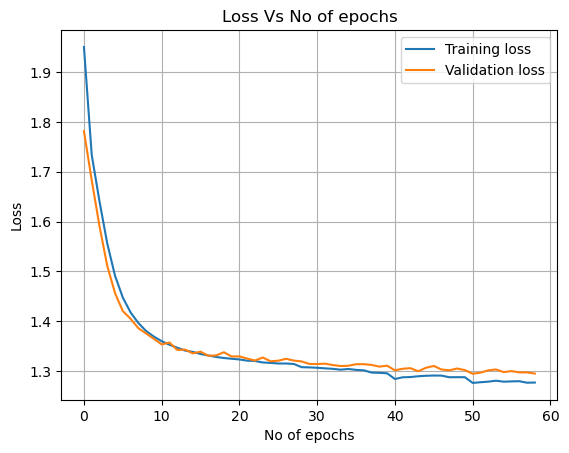

In [30]:
plt.plot(loss,label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.legend()
plt.grid()
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.title('Loss Vs No of epochs')
plt.show()

In [136]:
def predict_sentence(tokenizer, enc_dec_model, input_sentence):
    
    #Maximum sequence length for input and target sentence
    inp_max_length = 128
    out_max_length = 55
    
    input_sentence = '# ' + input_sentence + ' *'
    
    #Convert texts to sequences
    sent = tokenizer.texts_to_sequences([input_sentence])
    #Pad data
    sent = tf.keras.preprocessing.sequence.pad_sequences(sent, maxlen=inp_max_length, dtype='int32', padding='post')
    
    enc_outputs, enc_hidden, enc_cell = enc_dec_model.layers[0](sent)
    
    #Boundary case
    dec_input = tf.expand_dims([tokenizer.word_index['#']], 1)
    dec_hidden = enc_hidden
    dec_cell = enc_cell
    output_sent = '#'
    
    for i in range(out_max_length-1):

        #Get prediction from onestep_decoder
        dec_output, dec_hidden, dec_cell, attention_weights = enc_dec_model.layers[1].onestepdecoder(dec_input, enc_outputs, dec_hidden, dec_cell)
        
        #Extract predicted id from decoder output
        key = tf.argmax(dec_output[0]).numpy()
        
        #Get word corresponding to index
        output_sent+=str(tokenizer.index_word[key])
        
        if tokenizer.index_word[key] == '*':
            return output_sent,input_sentence,enc_outputs
        
        #Make current decoder output as decoder input for next time step
        dec_input = tf.expand_dims([key], 1)
    
    return output_sent, input_sentence

In [137]:
def prepro(x):
    l=re.compile("re:\s*|fw:\s*|fwd:\s*|fwd\s*", re.IGNORECASE)
    x=l.sub(" ", x)
    x=re.sub("[\n\t]", " ", x)
    x=re.sub("\s+", " ", x)
    x=x.strip()
    x=contractions.fix(x)
    x=BeautifulSoup(x, 'html.parser').get_text(separator=" ", strip=True)
    x=re.sub("<\!--.*?-->", "", x)
    x=re.sub("\s+", " ", x)
    l=re.compile('(http\S+)|(www\.\S+)|(\S+\.com)', re.IGNORECASE)
    x=l.sub('url', x)
    x=re.sub("\s+", " ", x)
    l=re.compile("\s\.com", re.IGNORECASE)
    x=l.sub("", x)
    x=re.sub("\s+", " ", x)
    lst=["\S+\s*\.dat", "\S+\s*\.xls", "\S+\s*\.pdf", "\S+\s*\.doc", "\S+\s*\.docx", "\S+\s*\.exe", "\S+\s*\.htm", "\S+\s*\.html", "\S+\s*\.net", "\S+\s*\.mso", "\S+\s*\.tif", "\S+\s*\.gif", "\S+\s*\.jpg", "\S+\s*\.jpeg", "\S+\s*\.ppt", "\S+\s*\.zip", "\S+\s*\.txt", "\S+\s*\.csv", "\S+\s*\.pst", "\S+\s*\.nsf", "\S+\s*\.ost", "\S+\s*\.xml", "\S+\s*\.sql", "\S+\s*\.jar", "\S+\s*\.bin", "\S+\s*\.asf", "\S+\s*\.mpeg", "\S+\s*\.pcx", "\S+\s*\.mpg", "\S+\s*\.mp3", "\S+\s*\.als", "\S+\s*\.wmz", "\S+\s*\.png", "\S+\s*\.vcf", "\S+\s*\.aud"]
    l=re.compile("|".join(lst), re.IGNORECASE)
    x=l.sub("", x)
    x=re.sub("\s+", " ", x)
    x=l.sub("", x)
    x=re.sub("\s+", " ", x)
    x=x.strip()
    x=x.lower()
    x=re.sub("[^a-z\s]", "", x)
    x=re.sub("\s+", " ", x)
    
    return x

In [138]:
def output(x):
    s=prepro(x)
    output_sent, input_sent, attention_plot = predict_sentence(tokenizer, model, s)
    output_sent=output_sent[2:-2]
    input_sent=input_sent[2:-2]
    print("Predicted Sentence:", output_sent)
    print("Complete Sentence:", input_sent+output_sent)

In [140]:
x=input("Input Sentence: ")
output(x)

Input Sentence: please provid
Predicted Sentence: e any comments
Complete Sentence: please provide any comments


In [39]:
x=input("Input Sentence: ")
output(x)

Input Sentence: where is my
Predicted Sentence:  company
Complete Sentence: where is my company


In [ ]:
x=input("Input Sentence: ")
output(x)

Input Sentence: we woul
Predicted Sentence: d like to talk to
Complete Sentence: we would like to talk to


In [ ]:
x=input("Input Sentence: ")
output(x)

Input Sentence: please provide t
Predicted Sentence: o the meeting
Complete Sentence: please provide to the meeting


In [ ]:
x=input("Input Sentence: ")
output(x)

Input Sentence: find the inf
Predicted Sentence: ormation
Complete Sentence: find the information


In [ ]:
x=input("Input Sentence: ")
output(x)

Input Sentence: where is m
Predicted Sentence: y contracts
Complete Sentence: where is my contracts


In [ ]:
x=input("Input Sentence: ")
output(x)

Input Sentence: kindly inform the director abou
Predicted Sentence: t the week
Complete Sentence: kindly inform the director about the week
